In [1]:
import blocksci

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import collections
import random

In [4]:
import utils

In [5]:
import analysis

In [6]:
import gc

In [7]:
import joblib

In [8]:
from utils import grouper

In [9]:
chain = blocksci.Blockchain(utils.blocksci_config())

In [10]:
datestring_new = "20210804"

In [11]:
my_cm = blocksci.cluster.ClusterManager(utils.latest_clustering(), chain)

In [12]:
my_cm.clusters().size

658522992

In [13]:
my_cm_cluster_id = blocksci.heuristics.cluster_id(my_cm)

In [14]:
my_cm_output_cluster_id = blocksci.heuristics.output_cluster_id(my_cm)

In [15]:
refined = blocksci.cluster.ClusterManager("/home/ubuntu/Data/clusters/{}-refined-smart".format(datestring_new), chain)

In [16]:
refined_output_cluster_id = blocksci.heuristics.output_cluster_id(refined)

In [17]:
refined.clusters().size

514253477

### Load address tags

In [18]:
import yaml

In [19]:
with open('walletexplorer.yaml') as f:
    cluster_tags = yaml.safe_load(f)

In [20]:
cluster_tags = cluster_tags['tags']

In [21]:
exchanges = set()
for entry in cluster_tags:
    if "category" in entry and entry["category"] == "exchange":
        exchanges.add(entry['label'])

In [22]:
len(exchanges)

117

In [23]:
markets = set()
for entry in cluster_tags:
    if "category" in entry and entry["category"] == "market":
        markets.add(entry['label'])

In [24]:
len(markets)

15

In [25]:
more_clusters = collections.defaultdict(set)
for entry in cluster_tags:
    address = chain.address_from_string(entry['address'])
    cluster_id = my_cm.cluster_with_address(address).index
    more_clusters[entry['label']].add(cluster_id)

In [26]:
more_clusters_refined = collections.defaultdict(set)
for entry in cluster_tags:
    address = chain.address_from_string(entry['address'])
    cluster_id = refined.cluster_with_address(address).index
    more_clusters_refined[entry['label']].add(cluster_id)

In [27]:
for key in more_clusters:
    if len(more_clusters[key]) > 1:
        if len(more_clusters[key]) != len(more_clusters_refined[key]):
            print(more_clusters[key])
            print(more_clusters_refined[key])
            print()

{112380035, 139741574, 163418121, 177463055, 158062353, 146620562, 150467859, 180919317, 137159322, 197339038, 247241886, 202244769, 169883685, 225165734, 141474473, 145315242, 241677486, 221188143, 185695538, 174243890, 120596916, 148875955, 206351679, 231674058, 195221710, 147018582, 153360993, 151190498, 209553253, 238500208, 193399793, 234622835, 199968371, 166609018, 160924157}
{141203331, 152894214, 145053073, 162327316, 105485332, 101625110, 170982428, 176635806, 165582762, 131537962, 73975084, 183823667, 123587766, 173414332, 119805123, 109552837, 179269958, 139742918, 150273615, 1023698, 99650009, 98424538, 112052575, 103613023, 142889446, 94912235, 126340590, 114198638, 93473518, 146900465, 69303414, 129275513, 88747004}



In [28]:
more_clusters['agoramarket']

{100336032}

In [29]:
more_clusters_refined['nucleusmarket']

{65662102}

In [30]:
more_clusters['bitfinex']

{93183304, 99849715, 120547605}

In [31]:
all_exchange_clusters = [x for lbl in exchanges for x in more_clusters[lbl]]

In [32]:
all_exchange_clusters_refined = [x for lbl in exchanges for x in more_clusters_refined[lbl]]

In [33]:
sent_to_exchanges = collections.defaultdict(int)
sent_to_exchanges_count = collections.defaultdict(int)

for market in markets:
    for cluster_id in more_clusters[market]:
        cluster = my_cm.clusters()[cluster_id]
        values = cluster.input_txes_fast().outputs.value
        destinations = cluster.input_txes_fast().outputs.map(lambda o: my_cm_output_cluster_id(o))
        value_sent = values[np.in1d(destinations, all_exchange_clusters)].sum()
        sent_to_exchanges[market] += value_sent
        sent_to_exchanges_count[market] += len(values[np.in1d(destinations, all_exchange_clusters)])

In [34]:
sent_to_exchanges_refined = collections.defaultdict(int)
sent_to_exchanges_count_refined = collections.defaultdict(int)

for market in markets:
    for cluster_id in more_clusters_refined[market]:
        cluster = refined.clusters()[cluster_id]
        values = cluster.input_txes_fast().outputs.value
        destinations = cluster.input_txes_fast().outputs.map(lambda o: refined_output_cluster_id(o))
        value_sent = values[np.in1d(destinations, all_exchange_clusters_refined)].sum()
        sent_to_exchanges_refined[market] += value_sent
        sent_to_exchanges_count_refined[market] += len(values[np.in1d(destinations, all_exchange_clusters_refined)])

In [37]:
tx_counts = collections.defaultdict(int)
address_counts = collections.defaultdict(int)

for market in markets:
    for cluster_id in more_clusters[market]:
        cluster = my_cm.clusters()[cluster_id]
        tx_counts[market] += cluster.tx_count
        address_counts[market] += len(cluster)

In [38]:
tx_counts_refined = collections.defaultdict(int)
address_counts_refined = collections.defaultdict(int)

for market in markets:
    for cluster_id in more_clusters_refined[market]:
        cluster = refined.clusters()[cluster_id]
        tx_counts_refined[market] += cluster.tx_count
        address_counts_refined[market] += len(cluster)

In [35]:
perc_changes = []
for lbl in sorted(sent_to_exchanges):
    starting = sent_to_exchanges[lbl]
    final = sent_to_exchanges_refined[lbl]
    perc_change = round(100*(final-starting)/starting, 2)
    perc_changes.append(perc_change)
    perc_change_outputs = round(100*(sent_to_exchanges_count_refined[lbl]-sent_to_exchanges_count[lbl])/sent_to_exchanges_count[lbl], 2)
    print(lbl, "&", sent_to_exchanges_count[lbl], "&", sent_to_exchanges_count_refined[lbl], "&", perc_change_outputs, "&", round(starting/1e8), "&", round(final/1e8), "&", perc_change, "\\\\")

abraxasmarket & 9202 & 11373 & 23.59 & 21925 & 23368 & 6.58 \\
agoramarket & 82218 & 108026 & 31.39 & 158360 & 170970 & 7.96 \\
alphabaymarket & 25646 & 33052 & 28.88 & 35496 & 41573 & 17.12 \\
babylonmarket & 422 & 616 & 45.97 & 222 & 283 & 27.13 \\
blackbankmarket & 3052 & 3987 & 30.64 & 8292 & 9245 & 11.49 \\
blueskymarket & 6581 & 9919 & 50.72 & 2520 & 3333 & 32.3 \\
cannabisroadmarket & 48 & 76 & 58.33 & 6 & 7 & 25.15 \\
doctordmarket & 414 & 621 & 50.0 & 224 & 277 & 23.92 \\
evolutionmarket & 20572 & 53335 & 159.26 & 49891 & 84637 & 69.64 \\
middleearthmarket & 5078 & 5410 & 6.54 & 11793 & 12021 & 1.93 \\
nucleusmarket & 23840 & 26760 & 12.25 & 45265 & 47006 & 3.85 \\
pandoraopenmarket & 8246 & 10399 & 26.11 & 8708 & 9461 & 8.64 \\
sheepmarket & 4487 & 5235 & 16.67 & 12104 & 13309 & 9.96 \\
silkroad2market & 32693 & 38251 & 17.0 & 47292 & 49559 & 4.79 \\
silkroadmarket & 15152 & 20369 & 34.43 & 421741 & 472282 & 11.98 \\


In [36]:
np.median(perc_changes)

11.49

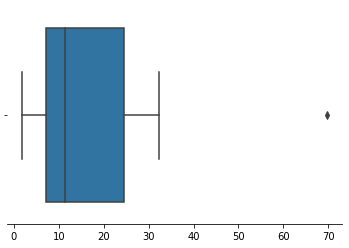

In [37]:
sns.boxplot(x=perc_changes)
sns.despine(left=True)

In [40]:
sum(sent_to_exchanges.values()) // 1e8

823839.0

In [41]:
sum(sent_to_exchanges_refined.values()) // 1e8

937330.0

In [43]:
(937330-823839) / (823839) * 100

13.775871256398398

In [67]:
sum(sent_to_exchanges_count.values())

237651

In [68]:
sum(sent_to_exchanges_count_refined.values())

327429

In [70]:
(327429-237651) / (237651) * 100

37.77724478331671